# LFP Extraction


## Overview


_Developer Note:_ if you may make a PR in the future, be sure to copy this
notebook, and use the `gitignore` prefix `temp` to avoid future conflicts.

This is one notebook in a multi-part series on Spyglass.

- To set up your Spyglass environment and database, see
  [the Setup notebook](./00_Setup.ipynb)
- For additional info on DataJoint syntax, including table definitions and
  inserts, see
  [the Insert Data notebook](./01_Insert_Data.ipynb)


## Imports


In [2]:
import os
import copy
import datajoint as dj
import numpy as np
import pandas as pd

# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
dj.config.load("dj_local_conf.json")  # load config for database connection info

import spyglass.common as sgc
import spyglass.lfp as lfp

# ignore datajoint+jupyter async warnings
import warnings

warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)

[2024-01-12 08:39:21,871][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2024-01-12 08:39:21,915][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306


## Select data


First, we select the NWB file, which corresponds to the dataset we want to extract LFP from.


In [3]:
nwb_file_name = "minirec20230622_.nwb"

## Create Filters


Next, we create the standard LFP Filters. This only needs to be done once.


In [4]:
sgc.FirFilterParameters().create_standard_filters()
sgc.FirFilterParameters()

filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,filter_type,filter_low_stop lowest frequency for stop band for low frequency side of filter,filter_low_pass lowest frequency for pass band of low frequency side of filter,filter_high_pass highest frequency for pass band for high frequency side of filter,filter_high_stop highest frequency for stop band of high frequency side of filter,filter_comments comments about the filter,filter_band_edges numpy array containing the filter bands (redundant with individual parameters),filter_coeff numpy array containing the filter coefficients
Delta 0.5-4 Hz,1000,lowpass,0.25,0.5,4.0,5.0,delta filter for 1 KHz data,=BLOB=,=BLOB=
"Delta 0.5-4 Hz pass, 0.25-4.5 Hz stop",1000,lowpass,0.25,0.5,4.0,4.5,revised delta filter for 1 KHz data,=BLOB=,=BLOB=
Epilepsy project 0.2-40 Hz,2000,bandpass,0.1,0.2,40.0,41.0,Sharp wave filter,=BLOB=,=BLOB=
Epilepsy project 140-800 Hz,2000,bandpass,135.0,140.0,800.0,825.0,Extended ripple filter,=BLOB=,=BLOB=
Epilepsy project 140-800 Hz ripple,2000,bandpass,135.0,140.0,800.0,825.0,Extended ripple filter,=BLOB=,=BLOB=
Epilepsy project 40-600 Hz,2000,bandpass,39.0,40.0,600.0,625.0,HFE filter,=BLOB=,=BLOB=
Fast Gamma 65-100 Hz,1000,bandpass,55.0,65.0,100.0,110.0,slow gamma filter for 1 Khz data,=BLOB=,=BLOB=
LFP 0-400 Hz,1000,lowpass,0.0,0.0,400.0,425.0,LFP filter for referencing,=BLOB=,=BLOB=
LFP 0-400 Hz,20000,lowpass,0.0,0.0,400.0,425.0,standard LFP filter for 20 KHz data,=BLOB=,=BLOB=
LFP 0-400 Hz,29995,lowpass,0.0,0.0,400.0,425.0,adapted LFP filter for Banner20220105,=BLOB=,=BLOB=


## Electrode Group


Now, we create an LFP electrode group, or the set of electrodes we want to
filter for LFP data. We can grab all electrodes and brain regions as a data
frame.


In [5]:
electrodes_df = (
    pd.DataFrame(
        (sgc.Electrode & {"nwb_file_name": nwb_file_name, "probe_electrode": 0})
        * sgc.BrainRegion
    )
    .loc[:, ["nwb_file_name", "electrode_id", "region_name"]]
    .sort_values(by="electrode_id")
)
electrodes_df

,nwb_file_name,electrode_id,region_name
0,minirec20230622_.nwb,0,corpus callosum and associated subcortical whi...
1,minirec20230622_.nwb,4,corpus callosum and associated subcortical whi...
12,minirec20230622_.nwb,8,corpus callosum and associated subcortical whi...
23,minirec20230622_.nwb,12,corpus callosum and associated subcortical whi...
26,minirec20230622_.nwb,16,corpus callosum and associated subcortical whi...
27,minirec20230622_.nwb,20,corpus callosum and associated subcortical whi...
28,minirec20230622_.nwb,24,corpus callosum and associated subcortical whi...
29,minirec20230622_.nwb,28,corpus callosum and associated subcortical whi...
30,minirec20230622_.nwb,32,corpus callosum and associated subcortical whi...
31,minirec20230622_.nwb,36,corpus callosum and associated subcortical whi...


For a larger dataset, we might want to filter by region, but our example
data only has one electrode.

```python
lfp_electrode_ids = electrodes_df.loc[
    electrodes_df.region_name == "ca1"
].electrode_id
```


In [6]:
lfp_electrode_ids = [0]
lfp_electrode_group_name = "test"
lfp_eg_key = {
    "nwb_file_name": nwb_file_name,
    "lfp_electrode_group_name": lfp_electrode_group_name,
}

lfp.lfp_electrode.LFPElectrodeGroup.create_lfp_electrode_group(
    nwb_file_name=nwb_file_name,
    group_name=lfp_electrode_group_name,
    electrode_list=lfp_electrode_ids,
)

We can verify the electrode list as follows


In [7]:
lfp.lfp_electrode.LFPElectrodeGroup.LFPElectrode() & {
    "nwb_file_name": nwb_file_name
}

nwb_file_name name of the NWB file,lfp_electrode_group_name the name of this group of electrodes,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode
minirec20230622_.nwb,test,0,0


## `IntervalList`


Recall from the [previous notebook](./02_Spike_Sorting.ipynb) that
`IntervalList` selects time frames from the experiment. We can select the
interval and subset to the first `n` seconds...


In [8]:
sgc.IntervalList & {"nwb_file_name": nwb_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start/end times for each interval,"pipeline type of interval list (e.g. 'position', 'spikesorting_recording_v1')"
minirec20230622_.nwb,01_s1,=BLOB=,
minirec20230622_.nwb,01_s1_first9,=BLOB=,
minirec20230622_.nwb,02_s2,=BLOB=,
minirec20230622_.nwb,pos 0 valid times,=BLOB=,
minirec20230622_.nwb,pos 1 valid times,=BLOB=,
minirec20230622_.nwb,raw data valid times,=BLOB=,


In [9]:
n = 9
orig_interval_list_name = "01_s1"
interval_list_name = orig_interval_list_name + f"_first{n}"

valid_times = (
    sgc.IntervalList
    & {
        "nwb_file_name": nwb_file_name,
        "interval_list_name": orig_interval_list_name,
    }
).fetch1("valid_times")

interval_key = {
    "nwb_file_name": nwb_file_name,
    "interval_list_name": interval_list_name,
    "valid_times": np.asarray([[valid_times[0, 0], valid_times[0, 0] + n]]),
}

sgc.IntervalList.insert1(
    interval_key,
    skip_duplicates=True,
)

In [10]:
sgc.IntervalList() & {
    "nwb_file_name": nwb_file_name,
    "interval_list_name": interval_list_name,
}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start/end times for each interval,"pipeline type of interval list (e.g. 'position', 'spikesorting_recording_v1')"
minirec20230622_.nwb,01_s1_first9,=BLOB=,


## `LFPSelection`


LFPSelection combines the data, interval and filter


In [23]:
lfp_s_key = copy.deepcopy(lfp_eg_key)

lfp_s_key.update(
    {
        "target_interval_list_name": interval_list_name,
        "filter_name": "LFP 0-400 Hz",
        "filter_sampling_rate": 30_000,  # sampling rate of the data (Hz)
        "target_sampling_rate": 1_000,  # smpling rate of the lfp output (Hz)
    }
)

lfp.v1.LFPSelection.insert1(lfp_s_key, skip_duplicates=True)

In [24]:
lfp.v1.LFPSelection() & lfp_s_key

nwb_file_name name of the NWB file,lfp_electrode_group_name the name of this group of electrodes,target_interval_list_name descriptive name of this interval list,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,"target_sampling_rate the desired output sampling rate, in HZ"
minirec20230622_.nwb,test,01_s1_first9,LFP 0-400 Hz,30000,1000.0


## Populate LFP


`LFPV1` has a similar `populate` command as we've seen before.

_Notes:_

- For full recordings, this takes ~2h when done locally, for all electrodes
- This `populate` also inserts into the LFP _Merge Table_, `LFPOutput`. For more
  on Merge Tables, see our documentation. In short, this collects different LFP
  processing streams into one table.


In [25]:
lfp.v1.LFPV1().populate(lfp_s_key)

We can now look at the LFP table to see the data we've extracted


In [26]:
lfp.LFPOutput.LFPV1() & lfp_s_key

merge_id,nwb_file_name name of the NWB file,lfp_electrode_group_name the name of this group of electrodes,target_interval_list_name descriptive name of this interval list,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter
1e7fbe35-034b-ed8e-7965-a0467ae5c0a4,minirec20230622_.nwb,test,01_s1_first9,LFP 0-400 Hz,30000


In [27]:
lfp_key = {"merge_id": (lfp.LFPOutput.LFPV1() & lfp_s_key).fetch1("merge_id")}
lfp_key

{'merge_id': UUID('1e7fbe35-034b-ed8e-7965-a0467ae5c0a4')}

In [28]:
lfp.LFPOutput & lfp_key

merge_id,source
1e7fbe35-034b-ed8e-7965-a0467ae5c0a4,LFPV1


From the Merge Table, we can get the keys for the LFP data we want to see


In [31]:
lfp_df = (lfp.LFPOutput & lfp_key).fetch1_dataframe()
lfp_df

,0
time,
1.687475e+09,21
1.687475e+09,10
1.687475e+09,37
1.687475e+09,81
1.687475e+09,61
...,...
1.687475e+09,-125
1.687475e+09,-126
1.687475e+09,-123


## LFP Band

Now that we've created the LFP object we can perform a second level of filtering for a band of interest, in this case the theta band. We first need to create the filter.


In [32]:
lfp_sampling_rate = lfp.LFPOutput.merge_get_parent(lfp_key).fetch1(
    "lfp_sampling_rate"
)

filter_name = "Theta 5-11 Hz"

sgc.common_filter.FirFilterParameters().add_filter(
    filter_name,
    lfp_sampling_rate,
    "bandpass",
    [4, 5, 11, 12],
    "theta filter for 1 Khz data",
)

sgc.common_filter.FirFilterParameters() & {
    "filter_name": filter_name,
    "filter_sampling_rate": lfp_sampling_rate,
}

filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,filter_type,filter_low_stop lowest frequency for stop band for low frequency side of filter,filter_low_pass lowest frequency for pass band of low frequency side of filter,filter_high_pass highest frequency for pass band for high frequency side of filter,filter_high_stop highest frequency for stop band of high frequency side of filter,filter_comments comments about the filter,filter_band_edges numpy array containing the filter bands (redundant with individual parameters),filter_coeff numpy array containing the filter coefficients
Theta 5-11 Hz,1000,lowpass,4.0,5.0,11.0,12.0,theta filter for 1 KHz data,=BLOB=,=BLOB=


In [33]:
sgc.IntervalList()

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start/end times for each interval,"pipeline type of interval list (e.g. 'position', 'spikesorting_recording_v1')"
aj8020230628_.nwb,02_lineartrack,=BLOB=,
aj8020230628_.nwb,04_lineartrack,=BLOB=,
aj8020230628_.nwb,06_lineartrack,=BLOB=,
aj8020230628_.nwb,pos 0 valid times,=BLOB=,
aj8020230628_.nwb,pos 1 valid times,=BLOB=,
aj8020230628_.nwb,pos 2 valid times,=BLOB=,
aj8020230628_.nwb,raw data valid times,=BLOB=,
aj8420230703_.nwb,01_lineartrack,=BLOB=,
aj8420230703_.nwb,pos 0 valid times,=BLOB=,
aj8420230703_.nwb,raw data valid times,=BLOB=,


We can specify electrodes of interest, and desired sampling rate.


In [34]:
from spyglass.lfp.analysis.v1 import lfp_band

lfp_band_electrode_ids = [0]  # assumes we've filtered these electrodes
lfp_band_sampling_rate = 100  # desired sampling rate

lfp_band.LFPBandSelection().set_lfp_band_electrodes(
    nwb_file_name=nwb_file_name,
    lfp_merge_id=lfp_key["merge_id"],
    electrode_list=lfp_band_electrode_ids,
    filter_name=filter_name,  # defined above
    interval_list_name=interval_list_name,  # Defined in IntervalList above
    reference_electrode_list=[-1],  # -1 means no ref electrode for all channels
    lfp_band_sampling_rate=lfp_band_sampling_rate,
)

lfp_band.LFPBandSelection()

lfp_merge_id,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,nwb_file_name name of the NWB file,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,min_interval_len the minimum length of a valid interval to filter
001d08a1-5365-3c20-716b-f431ab136a55,Theta 5-11 Hz,1000,Totoro20220602_.nwb,pos 4 valid times,100,1.0
00213375-550b-ae22-394b-82da3cdfddb3,Theta 5-11 Hz,1000,Yoshi20220518_.nwb,pos 15 valid times,100,1.0
004560d5-417b-ff99-5a13-99a37a3eb998,ripple_150_250,1000,j1620210715_.nwb,09_s5,1000,1.0
004560d5-417b-ff99-5a13-99a37a3eb998,theta_5_11,1000,j1620210715_.nwb,09_s5,1000,1.0
006b9516-88d1-dd58-75e6-e519fb7dfea8,ripple_150_250,1000,senor20201103_.nwb,15_s8,1000,1.0
006b9516-88d1-dd58-75e6-e519fb7dfea8,theta_5_11,1000,senor20201103_.nwb,15_s8,1000,1.0
0087e094-8238-32b8-9e8d-ecb7d9352b3b,Fast Gamma 65-100 Hz,1000,Winnie20220714_.nwb,pos 9 valid times,1000,1.0
0087e094-8238-32b8-9e8d-ecb7d9352b3b,ms_stim_125ms_period,1000,Winnie20220714_.nwb,pos 9 valid times,200,1.0
0087e094-8238-32b8-9e8d-ecb7d9352b3b,Ripple 150-250 Hz,1000,Winnie20220714_.nwb,pos 9 valid times,1000,1.0
0087e094-8238-32b8-9e8d-ecb7d9352b3b,Slow Gamma 25-55 Hz,1000,Winnie20220714_.nwb,pos 9 valid times,1000,1.0


Next we add an entry for the LFP Band and the electrodes we want to filter


In [39]:
lfp_band_key = (
    lfp_band.LFPBandSelection
    & {
        "lfp_merge_id": lfp_key["merge_id"],
        "filter_name": filter_name,
        "lfp_band_sampling_rate": lfp_band_sampling_rate,
    }
).fetch1("KEY")
lfp_band_key

{'lfp_merge_id': UUID('1e7fbe35-034b-ed8e-7965-a0467ae5c0a4'),
 'filter_name': 'Theta 5-11 Hz',
 'filter_sampling_rate': 1000,
 'nwb_file_name': 'minirec20230622_.nwb',
 'target_interval_list_name': '01_s1_first9',
 'lfp_band_sampling_rate': 100}

Check to make sure it worked


In [40]:
lfp_band.LFPBandSelection() & lfp_band_key

lfp_merge_id,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,nwb_file_name name of the NWB file,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,min_interval_len the minimum length of a valid interval to filter
1e7fbe35-034b-ed8e-7965-a0467ae5c0a4,Theta 5-11 Hz,1000,minirec20230622_.nwb,01_s1_first9,100,1.0


In [42]:
lfp_band.LFPBandV1().populate(lfp_band.LFPBandSelection() & lfp_band_key)
lfp_band.LFPBandV1() & lfp_band_key

lfp_merge_id,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,nwb_file_name name of the NWB file,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,analysis_file_name name of the file,interval_list_name descriptive name of this interval list,lfp_band_object_id the NWB object ID for loading this object from the file
1e7fbe35-034b-ed8e-7965-a0467ae5c0a4,Theta 5-11 Hz,1000,minirec20230622_.nwb,01_s1_first9,100,minirec20230622_DCP0O105KG.nwb,01_s1_first9 lfp band 100Hz,277bdc87-98b9-4eff-a33e-00b64b4c3bb2


## Plotting


Now we can plot the original signal, the LFP filtered trace, and the theta
filtered trace together. Get the three electrical series objects and the indices
of the electrodes we band pass filtered

_Note:_ Much of the code below could be replaced by a function calls that would
return the data from each electrical series.

_Note:_ If you see an error `Qt: Session Management Error`, try running the
following unix command: `export -n SESSION_MANAGER`.
[See also](https://stackoverflow.com/questions/986964/qt-session-management-error)


In [43]:
orig_eseries = (sgc.Raw() & {"nwb_file_name": nwb_file_name}).fetch_nwb()[0][
    "raw"
]
orig_elect_indices = sgc.get_electrode_indices(
    orig_eseries, lfp_band_electrode_ids
)
orig_timestamps = np.asarray(orig_eseries.timestamps)

In [44]:
lfp_eseries = lfp.LFPOutput().fetch_nwb(lfp_key)[0]["lfp"]
lfp_elect_indices = sgc.get_electrode_indices(
    lfp_eseries, lfp_band_electrode_ids
)
lfp_timestamps = np.asarray(lfp_eseries.timestamps)

In [45]:
lfp_band_eseries = (lfp_band.LFPBandV1 & lfp_band_key).fetch_nwb()[0][
    "lfp_band"
]
lfp_band_elect_indices = sgc.get_electrode_indices(
    lfp_band_eseries, lfp_band_electrode_ids
)
lfp_band_timestamps = np.asarray(lfp_band_eseries.timestamps)

Get a list of times for the first run epoch and then select a 2 second interval
100 seconds from the beginning


In [46]:
plottimes = [valid_times[0][0] + 1, valid_times[0][0] + 8]

In [47]:
# get the time indices for each dataset
orig_time_ind = np.where(
    np.logical_and(
        orig_timestamps > plottimes[0], orig_timestamps < plottimes[1]
    )
)[0]

lfp_time_ind = np.where(
    np.logical_and(lfp_timestamps > plottimes[0], lfp_timestamps < plottimes[1])
)[0]
lfp_band_time_ind = np.where(
    np.logical_and(
        lfp_band_timestamps > plottimes[0],
        lfp_band_timestamps < plottimes[1],
    )
)[0]

Text(0, 0.5, 'Amplitude (AD units)')

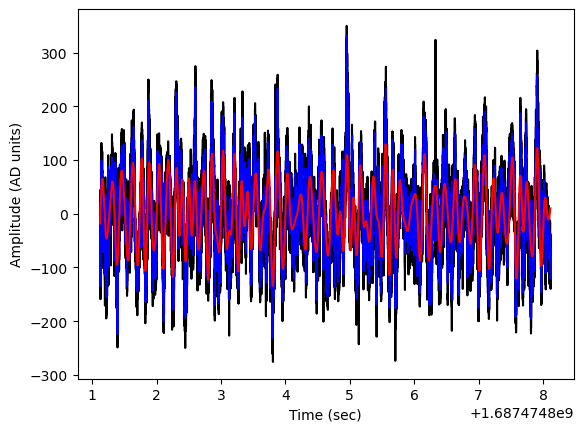

In [48]:
import matplotlib.pyplot as plt

plt.plot(
    orig_eseries.timestamps[orig_time_ind],
    orig_eseries.data[orig_time_ind, orig_elect_indices[0]],
    "k-",
)
plt.plot(
    lfp_eseries.timestamps[lfp_time_ind],
    lfp_eseries.data[lfp_time_ind, lfp_elect_indices[0]],
    "b-",
)
plt.plot(
    lfp_band_eseries.timestamps[lfp_band_time_ind],
    lfp_band_eseries.data[lfp_band_time_ind, lfp_band_elect_indices[0]],
    "r-",
)
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude (AD units)")

# Uncomment to see plot
# plt.show()

## Next Steps

Next, we'll use look at [Theta](./14_Theta.ipynb) bands within LFP data.
